In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Utils import Utils
from Constants import Constants
from Propensity_socre_network import Propensity_socre_network
from Utils import Utils
from PS_Manager import PS_Manager
from PS_Treated_Generator import PS_Treated_Generator

from GAN import Generator, Discriminator
from sklearn.neighbors import NearestNeighbors

from GAN_Manager import GAN_Manager
from Utils import Utils

from matplotlib import pyplot
from torch.autograd.variable import Variable
from collections import OrderedDict

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

from GAN_Manager import GAN_Manager
from Utils import Utils

def get_matched_and_unmatched_control_indices(ps_treated, ps_control):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(ps_control)
    distance, matched_control = nn.kneighbors(ps_treated)
    matched_control_indices = np.array(matched_control).ravel()

        # # remove duplicates
    #matched_control_indices = list(dict.fromkeys(matched_control_indices))
    set_matched_control_indices = set(matched_control_indices)
    total_indices = list(range(len(ps_control)))
    unmatched_control_indices = list(filter(lambda x: x not in set_matched_control_indices,
                                                total_indices))

    return matched_control_indices, unmatched_control_indices

def filter_control_groups(np_control_df_X, np_control_ps_score,
                              np_control_df_Y_f,
                              np_control_df_Y_cf, indices):
    np_filter_control_df_X = np.take(np_control_df_X, indices, axis=0)
    np_filter_control_ps_score = np.take(np_control_ps_score, indices, axis=0)
    np_filter_control_df_Y_f = np.take(np_control_df_Y_f, indices, axis=0)
    np_filter_control_df_Y_cf = np.take(np_control_df_Y_cf, indices, axis=0)
    tuple_matched_control = (np_filter_control_df_X, np_filter_control_ps_score,
                                 np_filter_control_df_Y_f, np_filter_control_df_Y_cf)

    return tuple_matched_control

def filter_matched_and_unmatched_control_samples(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f,
                                                     np_control_df_Y_cf, matched_control_indices,
                                                     unmatched_control_indices):
    tuple_matched_control = filter_control_groups(np_control_df_X, np_control_ps_score,
                                                           np_control_df_Y_f,
                                                           np_control_df_Y_cf,
                                                           matched_control_indices)

    tuple_unmatched_control = filter_control_groups(np_control_df_X, np_control_ps_score,
                                                             np_control_df_Y_f,
                                                             np_control_df_Y_cf,
                                                             unmatched_control_indices)

    return tuple_matched_control, tuple_unmatched_control

In [3]:
def get_ps_model(ps_model_type, iter_id,
                       input_nodes, device, 
                 np_covariates_X_train, np_covariates_X_test, np_covariates_Y_train, 
                 np_covariates_Y_test, dL):
    ps_train_set = dL.convert_to_tensor(np_covariates_X_train, 
                                             np_covariates_Y_train)
    ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                            np_covariates_Y_test)
    ps_manager = PS_Manager()
    if ps_model_type == Constants.PS_MODEL_NN:
        return ps_manager.get_propensity_scores(ps_train_set,
                                                    ps_test_set, iter_id,
                                                    input_nodes, device)


In [4]:
csv_path = "Dataset/ihdp_sample.csv"
from dataloader import DataLoader
split_size = 0.8
dL = DataLoader()
iter_id = 1
input_nodes = 25
device = Utils.get_device()

np_covariates_X_train, np_covariates_X_test, np_covariates_Y_train, np_covariates_Y_test \
                = dL.preprocess_data_from_csv(csv_path, split_size)

ps_train_set = dL.convert_to_tensor(np_covariates_X_train, np_covariates_Y_train)
# ps_score_list_train_NN = get_propensity_scores(ps_train_set, iter_id, input_nodes, device)

ps_model_type=Constants.PS_MODEL_NN
ps_score_list_train, ps_score_list_test, ps_model = get_ps_model(ps_model_type,iter_id,
                                                                input_nodes,
                                                                device,
                                                                np_covariates_X_train, np_covariates_X_test, 
                                                                np_covariates_Y_train, 
                                                                np_covariates_Y_test, dL)

############### Propensity Score neural net Training ###############
.. PS Training started ..
Epoch: 25, loss: 6.894181028008461, correct: 487/597, accuracy: 0.8157453936348409
Epoch: 50, loss: 4.5601475685834885, correct: 527/597, accuracy: 0.8827470686767169
Training Completed..


In [5]:
ps_score_list_train_NN = ps_score_list_train
print(len(ps_score_list_train_NN))
len(ps_score_list_test)

597


150

In [6]:
data_loader_dict_train = dL.prepare_tensor_for_DCN(np_covariates_X_train,
                                                              np_covariates_Y_train,
                                                              ps_score_list_train_NN,
                                                              False)

 Treated Statistics ==>
(110, 25)
 Control Statistics ==>
(487, 25)


In [7]:
tuple_treated = data_loader_dict_train["treated_data"]
tuple_control = data_loader_dict_train["control_data"]
np_treated_df_X, np_treated_ps_score, np_treated_df_Y_f, np_treated_df_Y_cf = tuple_treated
np_control_df_X, np_control_ps_score, np_control_df_Y_f, np_control_df_Y_cf = tuple_control

        # get unmatched controls
matched_control_indices, unmatched_control_indices = get_matched_and_unmatched_control_indices(
Utils.convert_to_col_vector(np_treated_ps_score),
Utils.convert_to_col_vector(np_control_ps_score))

print("Matched Control: {0}".format(len(matched_control_indices)))
print("Unmatched Control: {0}".format(len(unmatched_control_indices)))

tuple_matched_control, tuple_unmatched_control = filter_matched_and_unmatched_control_samples(
            np_control_df_X, np_control_ps_score,
            np_control_df_Y_f,
            np_control_df_Y_cf, matched_control_indices,
            unmatched_control_indices)

        # generate matched treated for unmatched controls using variable
        # tuple_unmatched_control
        # create GAN code here
print("Matched Control: {0}".format(tuple_matched_control[0].shape))
print("Matched Treated: {0}".format(tuple_treated[0].shape))
tensor_treated = \
            Utils.create_tensors_to_train_DCN(tuple_treated, dL)

        # need to change for unmatched
tensor_matched_control = \
            Utils.create_tensors_to_train_DCN(tuple_matched_control, dL)

tensor_unmatched_control = \
            Utils.create_tensors_to_train_DCN(tuple_unmatched_control, dL)

Matched Control: 110
Unmatched Control: 440
Matched Control: (110, 25)
Matched Treated: (110, 25)


In [59]:
for p in ps_model.network.parameters():
    if p.requires_grad:
         print(p.name, p.data)

None tensor([[ 6.5097e-04, -1.7002e-02, -3.0651e-01, -1.6960e-01, -1.8312e-01,
         -1.4993e-01, -1.4131e-01,  7.5601e-02,  1.0128e-02, -5.9462e-02,
          5.5825e-02,  3.9940e-02,  2.2372e-01, -4.0432e-02, -3.8436e-02,
         -8.0285e-02,  3.7613e-02, -1.5925e-01, -1.8394e-01,  2.2996e-01,
          1.5143e-01,  1.7001e-01,  2.2519e-01, -2.9983e-02, -6.2041e-02],
        [ 8.3384e-02, -3.6643e-02, -3.3339e-01, -7.2526e-02,  2.1678e-01,
         -1.0436e-01,  2.1112e-01, -2.6544e-01,  4.5422e-02,  4.9079e-02,
         -2.8169e-01,  9.1486e-03, -1.9106e-01, -4.2072e-02, -1.3664e-01,
          4.4773e-02,  6.8548e-02, -2.1993e-02, -1.7416e-01,  4.4245e-02,
          1.2394e-01,  3.3318e-01,  3.1456e-01,  1.4697e-01, -2.5896e-01],
        [ 6.2710e-03, -3.5689e-03,  3.9943e-02,  1.9882e-01,  1.0505e-01,
          2.5068e-02,  2.9301e-02, -1.0379e-01, -1.8220e-01, -1.8106e-01,
          1.0037e-01,  4.5255e-02, -2.9388e-01,  4.1484e-02,  5.3230e-02,
          1.6032e-01, -1.1235e-

In [8]:
def draw(treated_ps_list, control_ps_list, bins1):
    pyplot.hist(treated_ps_list, bins1, alpha=0.5, label='treated')
    pyplot.hist(control_ps_list, bins1, alpha=0.5, label='control')

    pyplot.legend(loc='upper right')
    pyplot.show()

In [9]:
ps_matched_control_list = tuple_matched_control[1].tolist()
ps_un_matched_control_list = tuple_unmatched_control[1].tolist()
ps_treated_list = tuple_treated[1].tolist()

print(len(ps_matched_control_list), len(ps_treated_list))

110 110


In [10]:
bins1 = np.linspace(0, 1, 100)
bins2 = np.linspace(0, 0.2, 100)
bins3 = np.linspace(0.2, 0.5, 100)
bins4 = np.linspace(0.5, 1, 100)

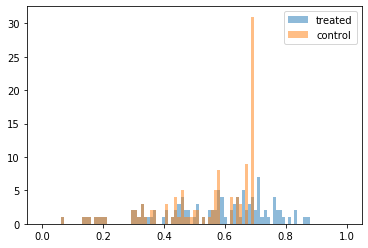

In [11]:
# matched control and treated
draw(ps_treated_list, ps_matched_control_list, bins1)

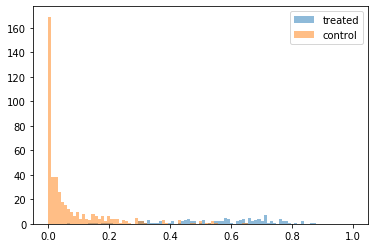

In [12]:
# unmatched control and treated
draw(ps_treated_list, ps_un_matched_control_list, bins1)

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable

from GAN import Generator, Discriminator
from Utils import Utils


class GAN_Module:
    def __init__(self, discriminator_in_nodes, generator_out_nodes, ps_model, device):
        self.discriminator = Discriminator(in_nodes=discriminator_in_nodes).to(device)
        self.discriminator.apply(self.__weights_init)

        self.generator = Generator(out_nodes=generator_out_nodes).to(device)
        self.generator.apply(self.__weights_init)

        self.loss = nn.BCELoss()
        self.ps_model = ps_model

    def get_generator(self):
        return self.generator

    def train_GAN(self, train_parameters, device):
        epochs = train_parameters["epochs"]
        train_set = train_parameters["train_set"]
        lr = train_parameters["lr"]
        shuffle = train_parameters["shuffle"]
        batch_size = train_parameters["batch_size"]
        BETA = train_parameters["BETA"]

        data_loader_train = torch.utils.data.DataLoader(train_set,
                                                        batch_size=batch_size,
                                                        shuffle=shuffle)

        g_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)

        for epoch in range(epochs):
            epoch += 1

            total_G_loss = 0
            total_D_loss = 0
            total_prop_loss = 0
            total_d_pred_real = 0
            total_d_pred_fake = 0

            for batch in data_loader_train:
                covariates_X_control, ps_score_control, y_f, y_cf = batch
                covariates_X_control = covariates_X_control.to(device)
                covariates_X_control_size = covariates_X_control.size(0)
                ps_score_control = ps_score_control.squeeze().to(device)

                # 1. Train Discriminator
                real_data = covariates_X_control

                # Generate fake data
                fake_data = self.generator(self.__noise(covariates_X_control_size)).detach()
                # Train D
                d_error, d_pred_real, d_pred_fake = self.__train_discriminator(d_optimizer,
                                                                               real_data, fake_data)
                total_D_loss += d_error
                total_d_pred_real += d_pred_real
                total_d_pred_fake += d_pred_fake

                # 2. Train Generator
                # Generate fake data
                fake_data = self.generator(self.__noise(covariates_X_control_size))
                # Train G
                error_g, prop_loss = self.__train_generator(g_optimizer, fake_data, BETA, ps_score_control,
                                                            device)
                total_G_loss += error_g
                total_prop_loss += prop_loss

            if epoch % 1000 == 0:
                print("Epoch: {0}, D_loss: {1}, D_score_real: {2}, D_score_Fake: {3}, G_loss: {4}, "
                      "Prop_loss: {5}"
                      .format(epoch,
                              total_D_loss, total_d_pred_real, total_d_pred_fake, total_G_loss, total_prop_loss))

    def eval_GAN(self, eval_size, device):
        treated_g = self.generator(self.__noise(eval_size))
        ps_score_list_treated = self.__get_propensity_score(treated_g, device)
        return treated_g, ps_score_list_treated

    def __cal_propensity_loss(self, ps_score_control,
                              gen_treated, device):
        ps_score_list_treated = self.__get_propensity_score(gen_treated, device)

        ps_score_treated = torch.tensor(ps_score_list_treated).to(device)
        ps_score_control = ps_score_control.to(device)
        prop_loss = torch.sum((torch.sub(ps_score_treated.float(),
                                         ps_score_control.float())) ** 2)
        return prop_loss

    def __get_propensity_score(self, gen_treated, device):
        # Assign Treated
        Y = np.ones(gen_treated.size(0))
        eval_set = Utils.convert_to_tensor(gen_treated.cpu().detach().numpy(), Y)
        ps_eval_parameters_NN = {
            "eval_set": eval_set
        }
        ps_score_list_treated = self.ps_model.eval(ps_eval_parameters_NN, device,
                                                   eval_from_GAN=True)
        return ps_score_list_treated

    @staticmethod
    def __noise(_size):
        n = Variable(torch.normal(mean=0, std=1, size=(_size, 25)))
        # print(n.size())
        if torch.cuda.is_available(): return n.cuda()
        return n

    @staticmethod
    def __weights_init(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

    @staticmethod
    def __real_data_target(size):
        data = Variable(torch.ones(size, 1))
        if torch.cuda.is_available(): return data.cuda()
        return data

    @staticmethod
    def __fake_data_target(size):
        data = Variable(torch.zeros(size, 1))
        if torch.cuda.is_available(): return data.cuda()
        return data

    def __train_discriminator(self, optimizer, real_data, fake_data):
        # Reset gradients
        optimizer.zero_grad()

        # 1.1 Train on Real Data
        prediction_real = self.discriminator(real_data)
        real_score = torch.mean(prediction_real).item()

        # Calculate error and back propagate
        error_real = self.loss(prediction_real, self.__real_data_target(real_data.size(0)))
        error_real.backward()

        # 1.2 Train on Fake Data
        prediction_fake = self.discriminator(fake_data)
        fake_score = torch.mean(prediction_fake).item()
        # Calculate error and backpropagate
        error_fake = self.loss(prediction_fake, self.__fake_data_target(real_data.size(0)))
        error_fake.backward()

        # 1.3 Update weights with gradients
        optimizer.step()
        loss_D = error_real + error_fake
        # Return error
        return loss_D.item(), real_score, fake_score

    def __train_generator(self, optimizer, fake_data, BETA, ps_score_control,
                          device):
        # 2. Train Generator
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        predicted_D = self.discriminator(fake_data)
        # Calculate error and back propagate
        ps_score_control = ps_score_control.to(device)
        fake_data = fake_data.to(device)
        error_g = self.loss(predicted_D, self.__real_data_target(predicted_D.size(0)))
        prop_loss = self.__cal_propensity_loss(ps_score_control,
                                               fake_data, device)
        error = error_g + (BETA * prop_loss)
        error.backward()
        # Update weights with gradients
        optimizer.step()
        # Return error
        return error_g.item(), prop_loss.item()


In [14]:
Constants.GAN_EPOCHS

10000

In [15]:
# GAN Part from here
GAN_train_parameters = {
            "epochs": Constants.GAN_EPOCHS,
            "lr": Constants.GAN_LR,
            "shuffle": True,
            "train_set": tensor_unmatched_control,
            "batch_size": Constants.GAN_BATCH_SIZE,
            "BETA": Constants.GAN_BETA
        }

gan = GAN_Module(Constants.GAN_DISCRIMINATOR_IN_NODES,
                          Constants.GAN_GENERATOR_OUT_NODES,
                          ps_model, device)
gan.train_GAN(GAN_train_parameters, device=device)

Epoch: 1000, D_loss: 6.484352111816406, D_score_real: 4.753779768943787, D_score_Fake: 2.244253993034363, G_loss: 8.261410355567932, Prop_loss: 84.21545600891113
Epoch: 2000, D_loss: 6.237849414348602, D_score_real: 4.846515357494354, D_score_Fake: 2.209312289953232, G_loss: 8.409345030784607, Prop_loss: 22.815560579299927
Epoch: 3000, D_loss: 5.379218220710754, D_score_real: 5.202274680137634, D_score_Fake: 1.7526859790086746, G_loss: 9.912554264068604, Prop_loss: 17.027713894844055
Epoch: 4000, D_loss: 4.714742660522461, D_score_real: 5.47422581911087, D_score_Fake: 1.536693200469017, G_loss: 10.902239441871643, Prop_loss: 51.16793727874756
Epoch: 5000, D_loss: 4.323586106300354, D_score_real: 5.580657243728638, D_score_Fake: 1.570993259549141, G_loss: 10.773802042007446, Prop_loss: 32.96702814102173
Epoch: 6000, D_loss: 4.604784965515137, D_score_real: 5.662094533443451, D_score_Fake: 1.5359097868204117, G_loss: 12.217398405075073, Prop_loss: 43.44487428665161
Epoch: 7000, D_loss: 4

In [60]:
for p in ps_model.network.parameters():
    if p.requires_grad:
         print(p.name, p.data)

None tensor([[ 6.5097e-04, -1.7002e-02, -3.0651e-01, -1.6960e-01, -1.8312e-01,
         -1.4993e-01, -1.4131e-01,  7.5601e-02,  1.0128e-02, -5.9462e-02,
          5.5825e-02,  3.9940e-02,  2.2372e-01, -4.0432e-02, -3.8436e-02,
         -8.0285e-02,  3.7613e-02, -1.5925e-01, -1.8394e-01,  2.2996e-01,
          1.5143e-01,  1.7001e-01,  2.2519e-01, -2.9983e-02, -6.2041e-02],
        [ 8.3384e-02, -3.6643e-02, -3.3339e-01, -7.2526e-02,  2.1678e-01,
         -1.0436e-01,  2.1112e-01, -2.6544e-01,  4.5422e-02,  4.9079e-02,
         -2.8169e-01,  9.1486e-03, -1.9106e-01, -4.2072e-02, -1.3664e-01,
          4.4773e-02,  6.8548e-02, -2.1993e-02, -1.7416e-01,  4.4245e-02,
          1.2394e-01,  3.3318e-01,  3.1456e-01,  1.4697e-01, -2.5896e-01],
        [ 6.2710e-03, -3.5689e-03,  3.9943e-02,  1.9882e-01,  1.0505e-01,
          2.5068e-02,  2.9301e-02, -1.0379e-01, -1.8220e-01, -1.8106e-01,
          1.0037e-01,  4.5255e-02, -2.9388e-01,  4.1484e-02,  5.3230e-02,
          1.6032e-01, -1.1235e-

In [57]:
treated_generated, ps_score_list_treated = gan.eval_GAN(tuple_unmatched_control[0].shape[0],
                                                                device)
len(ps_score_list_treated)

440

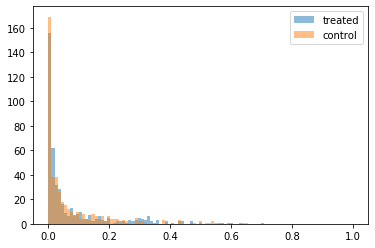

In [58]:
# treated by GAN vs unmactched control
draw(ps_score_list_treated, ps_un_matched_control_list, bins1)

# Inference Net

In [61]:
class TARNetPhi(nn.Module):
    def __init__(self, input_nodes, shared_nodes=200):
        super(TARNetPhi, self).__init__()

        # shared layer
        self.shared1 = nn.Linear(in_features=input_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared1.weight)
        nn.init.zeros_(self.shared1.bias)

        self.shared2 = nn.Linear(in_features=shared_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared2.weight)
        nn.init.zeros_(self.shared2.bias)

        self.shared3 = nn.Linear(in_features=shared_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared3.weight)
        nn.init.zeros_(self.shared3.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()
        # shared layers
        x = F.relu(self.shared1(x))
        x = F.relu(self.shared2(x))
        x = F.relu(self.shared3(x))

        return x


class TARNetH_Y1(nn.Module):
    def __init__(self, input_nodes=200, outcome_nodes=100):
        super(TARNetH_Y1, self).__init__()

        # potential outcome1 Y(1)
        self.hidden1_Y1 = nn.Linear(in_features=input_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden1_Y1.weight)
        nn.init.zeros_(self.hidden1_Y1.bias)

        self.hidden2_Y1 = nn.Linear(in_features=outcome_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden2_Y1.weight)
        nn.init.zeros_(self.hidden2_Y1.bias)

        self.out_Y1 = nn.Linear(in_features=outcome_nodes, out_features=1)
        nn.init.xavier_uniform_(self.out_Y1.weight)
        nn.init.zeros_(self.out_Y1.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        # potential outcome1 Y(1)
        y1 = F.relu(self.hidden1_Y1(x))
        y1 = F.relu(self.hidden2_Y1(y1))
        y1 = self.out_Y1(y1)

        return y1


class TARNetH_Y0(nn.Module):
    def __init__(self, input_nodes=200, outcome_nodes=100):
        super(TARNetH_Y0, self).__init__()

        # potential outcome1 Y(0)
        self.hidden1_Y0 = nn.Linear(in_features=input_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden1_Y0.weight)
        nn.init.zeros_(self.hidden1_Y0.bias)

        self.hidden2_Y0 = nn.Linear(in_features=outcome_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden2_Y0.weight)
        nn.init.zeros_(self.hidden2_Y0.bias)

        self.out_Y0 = nn.Linear(in_features=outcome_nodes, out_features=1)
        nn.init.xavier_uniform_(self.out_Y0.weight)
        nn.init.zeros_(self.out_Y0.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        # potential outcome1 Y(0)
        y0 = F.relu(self.hidden1_Y0(x))
        y0 = F.relu(self.hidden2_Y0(y0))
        y0 = self.out_Y0(y0)

        return y0



In [62]:
class PS_Matching:
    def match_using_prop_score(self, tuple_treated, tuple_control):
        matched_controls = []

        # do ps match
        np_treated_df_X, np_treated_ps_score, np_treated_df_Y_f, np_treated_df_Y_cf = tuple_treated
        np_control_df_X, np_control_ps_score, np_control_df_Y_f, np_control_df_Y_cf = tuple_control

        # get unmatched controls
        matched_control_indices, unmatched_control_indices = self.get_matched_and_unmatched_control_indices(
            Utils.convert_to_col_vector(np_treated_ps_score),
            Utils.convert_to_col_vector(np_control_ps_score))

        tuple_matched_control, tuple_unmatched_control = self.filter_matched_and_unmatched_control_samples(
            np_control_df_X, np_control_ps_score,
            np_control_df_Y_f,
            np_control_df_Y_cf, matched_control_indices,
            unmatched_control_indices)

        return tuple_matched_control

    def filter_matched_and_unmatched_control_samples(self, np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f,
                                                     np_control_df_Y_cf, matched_control_indices,
                                                     unmatched_control_indices):
        tuple_matched_control = self.filter_control_groups(np_control_df_X, np_control_ps_score,
                                                           np_control_df_Y_f,
                                                           np_control_df_Y_cf,
                                                           matched_control_indices)

        tuple_unmatched_control = self.filter_control_groups(np_control_df_X, np_control_ps_score,
                                                             np_control_df_Y_f,
                                                             np_control_df_Y_cf,
                                                             unmatched_control_indices)

        return tuple_matched_control, tuple_unmatched_control

    @staticmethod
    def filter_control_groups(np_control_df_X, np_control_ps_score,
                              np_control_df_Y_f,
                              np_control_df_Y_cf, indices):
        np_filter_control_df_X = np.take(np_control_df_X, indices, axis=0)
        np_filter_control_ps_score = np.take(np_control_ps_score, indices, axis=0)
        np_filter_control_df_Y_f = np.take(np_control_df_Y_f, indices, axis=0)
        np_filter_control_df_Y_cf = np.take(np_control_df_Y_cf, indices, axis=0)
        tuple_matched_control = (np_filter_control_df_X, np_filter_control_ps_score,
                                 np_filter_control_df_Y_f, np_filter_control_df_Y_cf)

        return tuple_matched_control

    @staticmethod
    def get_matched_and_unmatched_control_indices(ps_treated, ps_control):
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(ps_control)
        distance, matched_control = nn.kneighbors(ps_treated)
        matched_control_indices = np.array(matched_control).ravel()

        # remove duplicates
        # matched_control_indices = list(dict.fromkeys(matched_control_indices))
        set_matched_control_indices = set(matched_control_indices)
        total_indices = list(range(len(ps_control)))
        unmatched_control_indices = list(filter(lambda x: x not in set_matched_control_indices,
                                                total_indices))

        return matched_control_indices, unmatched_control_indices

    @staticmethod
    def get_unmatched_prop_list(tensor_unmatched_control):
        control_data_loader_train = torch.utils.data.DataLoader(tensor_unmatched_control,
                                                                batch_size=1,
                                                                shuffle=False,
                                                                num_workers=1)
        ps_unmatched_control_list = []
        for batch in control_data_loader_train:
            covariates_X, ps_score, y_f, y_cf = batch
            ps_unmatched_control_list.append(ps_score.item())

        return ps_unmatched_control_list

In [63]:
class InferenceNet:
    def __init__(self, input_nodes, shared_nodes, outcome_nodes, device):
        self.tarnet_phi = TARNetPhi(input_nodes, shared_nodes=shared_nodes).to(device)

        self.tarnet_h_y1 = TARNetH_Y1(input_nodes=shared_nodes,
                                      outcome_nodes=outcome_nodes).to(device)

        self.tarnet_h_y0 = TARNetH_Y0(input_nodes=shared_nodes,
                                      outcome_nodes=outcome_nodes).to(device)

    def get_tarnet_phi(self):
        return self.tarnet_phi

    def get_tarnet_h_y1(self):
        return self.tarnet_h_y1

    def get_tarnet_h_y0_model(self):
        return self.tarnet_h_y0

    def train_semi_supervised(self, train_parameters, n_total, n_treated, device):
        epochs = train_parameters["epochs"]
        batch_size = train_parameters["batch_size"]
        lr = train_parameters["lr"]
        weight_decay = train_parameters["lambda"]
        shuffle = train_parameters["shuffle"]
        tensor_dataset = train_parameters["tensor_dataset"]
        u = n_treated / n_total
        weight_t = 1 / (2 * u)
        weight_c = 1 / (2 * (1 - u))

        treated_data_loader_train = torch.utils.data.DataLoader(tensor_dataset,
                                                                batch_size=batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        optimizer_W = optim.Adam(self.tarnet_phi.parameters(), lr=lr)
        optimizer_V1 = optim.Adam(self.tarnet_h_y1.parameters(), lr=lr, weight_decay=weight_decay)
        optimizer_V2 = optim.Adam(self.tarnet_h_y0.parameters(), lr=lr, weight_decay=weight_decay)
        lossF = nn.MSELoss()
        print(".. Training started ..")
        print(device)
        for epoch in range(epochs):
            epoch += 1
            total_loss_T = 0
            total_loss_C = 0
            for batch in treated_data_loader_train:
                covariates_X, ps_score, T, y_f, y_cf = batch
                covariates_X = covariates_X.to(device)
                ps_score = ps_score.squeeze().to(device)

                idx = (T == 1)
                covariates_X_treated = covariates_X[idx]
                y_f_treated = y_f[idx]
                covariates_X_control = covariates_X[~idx]
                y_f_control = y_f[~idx]

                treated_size = covariates_X_treated.size(0)
                control_size = covariates_X_control.size(0)
                
                optimizer_W.zero_grad()
                optimizer_V1.zero_grad()
                optimizer_V2.zero_grad()

                if treated_size > 0:
                    y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X_treated))
                    if torch.cuda.is_available():
                        loss_T = weight_t * lossF(y1_hat.float().cuda(),
                                                  y_f_treated.float().cuda()).to(device)
                    else:
                        loss_T = weight_t * lossF(y1_hat.float(),
                                                  y_f_treated.float()).to(device)
                    loss_T.backward()
                    total_loss_T += loss_T.item()

                if control_size > 0:
                    y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X_control))
                    if torch.cuda.is_available():
                        loss_C = weight_c * lossF(y0_hat.float().cuda(),
                                                  y_f_control.float().cuda()).to(device)
                    else:
                        loss_C = weight_c * lossF(y0_hat.float(),
                                                  y_f_control.float()).to(device)
                    loss_C.backward()
                    total_loss_C += loss_C.item()



                optimizer_W.step()

                if treated_size > 0:
                    optimizer_V1.step()
                if control_size > 0:
                    optimizer_V2.step()

            if epoch % 40 == 0:
                print("epoch: {0}, Treated + Control loss: {1}".format(epoch, total_loss_T + total_loss_C))

    def eval_semi_supervised(self, eval_parameters, device, treated_flag):
        eval_set = eval_parameters["tensor_dataset"]

        _data_loader = torch.utils.data.DataLoader(eval_set,
                                                   shuffle=False, num_workers=1)

        y_f_list = []
        y_cf_list = []

        for batch in _data_loader:
            covariates_X, ps_score = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X))
            y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X))
            if treated_flag:
                y_f_list.append(y1_hat.item())
                y_cf_list.append(y0_hat.item())
            else:
                y_f_list.append(y0_hat.item())
                y_cf_list.append(y1_hat.item())

        return {
            "y_f_list": np.array(y_f_list),
            "y_cf_list": np.array(y_cf_list)
        }

    def train(self, train_parameters, device):
        epochs = train_parameters["epochs"]
        batch_size = train_parameters["batch_size"]
        lr = train_parameters["lr"]
        weight_decay = train_parameters["lambda"]
        shuffle = train_parameters["shuffle"]
        treated_tensor_dataset = train_parameters["treated_tensor_dataset"]
        tuple_control = train_parameters["tuple_control_train"]

        treated_data_loader_train = torch.utils.data.DataLoader(treated_tensor_dataset,
                                                                batch_size=batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        optimizer_W = optim.Adam(self.tarnet_phi.parameters(), lr=lr)
        optimizer_V1 = optim.Adam(self.tarnet_h_y1.parameters(), lr=lr, weight_decay=weight_decay)
        optimizer_V2 = optim.Adam(self.tarnet_h_y0.parameters(), lr=lr, weight_decay=weight_decay)
        lossF = nn.MSELoss()
        print(".. Training started ..")
        print(device)
        for epoch in range(epochs):
            epoch += 1
            total_loss_T = 0
            total_loss_C = 0
            for batch in treated_data_loader_train:
                covariates_X_treated, ps_score_treated, y_f_treated, y_cf_treated = batch
                covariates_X_treated = covariates_X_treated.to(device)
                ps_score_treated = ps_score_treated.squeeze().to(device)

                _tuple_treated = self.get_np_tuple_from_tensor(covariates_X_treated, ps_score_treated,
                                                               y_f_treated, y_cf_treated)
                psm = PS_Matching()
                tuple_matched_control = psm.match_using_prop_score(_tuple_treated, tuple_control)

                covariates_X_control, ps_score_control, y_f_control, y_cf_control = \
                    self.get_tensor_from_np_tuple(tuple_matched_control)

                y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X_treated))
                y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X_control))

                if torch.cuda.is_available():
                    loss_T = lossF(y1_hat.float().cuda(),
                                   y_f_treated.float().cuda()).to(device)
                    loss_C = lossF(y0_hat.float().cuda(),
                                   y_f_control.float().cuda()).to(device)
                else:
                    loss_T = lossF(y1_hat.float(),
                                   y_f_treated.float()).to(device)
                    loss_C = lossF(y0_hat.float(),
                                   y_f_control.float()).to(device)

                optimizer_W.zero_grad()
                optimizer_V1.zero_grad()
                optimizer_V2.zero_grad()
                loss_T.backward()
                loss_C.backward()
                optimizer_W.step()
                optimizer_V1.step()
                optimizer_V2.step()
                total_loss_T += loss_T.item()
                total_loss_C += loss_C.item()

            if epoch % 40 == 0:
                print("epoch: {0}, Treated + Control loss: {1}".format(epoch, total_loss_T + total_loss_C))

    def eval(self, eval_parameters, device):
        treated_set = eval_parameters["treated_set"]
        control_set = eval_parameters["control_set"]
        treated_data_loader = torch.utils.data.DataLoader(treated_set,
                                                          shuffle=False, num_workers=1)
        control_data_loader = torch.utils.data.DataLoader(control_set,
                                                          shuffle=False, num_workers=1)

        err_treated_list = []
        err_control_list = []
        true_ITE_list = []
        predicted_ITE_list = []

        ITE_dict_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X))
            y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X))

            predicted_ITE = y1_hat - y0_hat
            true_ITE = y_f - y_cf

            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            # ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
            #                                           ps_score.item(), y_f.item(),
            #                                           y_cf.item(),
            #                                           true_ITE.item(),
            #                                           predicted_ITE.item(),
            #                                           diff.item()))
            err_treated_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        for batch in control_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)

            y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X))
            y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X))

            predicted_ITE = y1_hat - y0_hat
            true_ITE = y_cf - y_f
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            # ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
            #                                           ps_score.item(), y_f.item(),
            #                                           y_cf.item(),
            #                                           true_ITE.item(),
            #                                           predicted_ITE.item(),
            #                                           diff.item()))
            err_control_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        # print(err_treated_list)
        # print(err_control_list)
        return {
            "treated_err": err_treated_list,
            "control_err": err_control_list,
            "true_ITE": true_ITE_list,
            "predicted_ITE": predicted_ITE_list,
            "ITE_dict_list": ITE_dict_list
        }

    @staticmethod
    def get_np_tuple_from_tensor(covariates_X, ps_score, y_f, y_cf):
        np_covariates_X = covariates_X.numpy()
        ps_score = ps_score.numpy()
        y_f = y_f.numpy()
        y_cf = y_cf.numpy()
        _tuple = (np_covariates_X, ps_score, y_f, y_cf)

        return _tuple

    @staticmethod
    def get_tensor_from_np_tuple(_tuple):
        np_df_X, np_ps_score, np_df_Y_f, np_df_Y_cf = _tuple
        return torch.from_numpy(np_df_X), torch.from_numpy(np_ps_score), \
               torch.from_numpy(np_df_Y_f), torch.from_numpy(np_df_Y_cf),

In [64]:
def convert_to_tensor_DCN_PS(tensor_x, ps_score):
    tensor_ps_score = torch.from_numpy(ps_score)
    processed_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_ps_score)
    return processed_dataset

def convert_to_tensor_DCN_semi_supervised(X, ps_score, T, Y_f, Y_cf):
    tensor_x = torch.stack([torch.Tensor(i) for i in X])
    tensor_ps_score = torch.from_numpy(ps_score)
    tensor_T = torch.from_numpy(T)
    tensor_y_f = torch.from_numpy(Y_f)
    tensor_y_cf = torch.from_numpy(Y_cf)
    processed_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_ps_score, tensor_T,
                                                           tensor_y_f, tensor_y_cf)
    return processed_dataset    

def create_tensors_to_train_DCN_semi_supervised(group):
    np_df_X = group[0]
    np_ps_score = group[1]
    T = group[2]
    np_df_Y_f = group[3]
    np_df_Y_cf = group[4]
    tensor = convert_to_tensor_DCN_semi_supervised(np_df_X, np_ps_score, T,
                                             np_df_Y_f, np_df_Y_cf)
    return tensor

# Semi Supervised Unbalanced Data

In [65]:
print("### DCN semi supervised training Unbalanced ###")
np_treated_x, np_treated_ps, np_treated_f, np_treated_cf = data_loader_dict_train["treated_data"]
np_control_x, np_control_ps, np_control_f, np_control_cf = data_loader_dict_train["control_data"]

t_1 = np.ones(np_treated_x.shape[0])
t_0 = np.zeros(np_control_x.shape[0])

n_treated = np_treated_x.shape[0]
n_control = np_control_x.shape[0]
n_total = n_treated + n_control

np_train_ss_X = np.concatenate((np_treated_x, np_control_x), axis=0)
np_train_ss_ps = np.concatenate((np_treated_ps, np_control_ps), axis=0)
np_train_ss_T = np.concatenate((t_1, t_0), axis=0)
np_train_ss_f = np.concatenate((np_treated_f, np_control_f), axis=0)
np_train_ss_cf = np.concatenate((np_treated_cf, np_control_cf), axis=0)


print(np_treated_x.shape[0])
print(np_control_x.shape[0])
print(np_train_ss_X.shape)

train_set = create_tensors_to_train_DCN_semi_supervised((np_train_ss_X, np_train_ss_ps, 
                                                         np_train_ss_T, np_train_ss_f, 
                                                         np_train_ss_cf))
train_parameters = {
                "epochs": 200,
                "lr": 1e-3,
                "lambda":1e-4,
                "batch_size": 64,
                "shuffle": True,
                "tensor_dataset": train_set
    }

inference_semi_supervised = InferenceNet(input_nodes=25, shared_nodes=200, 
                         outcome_nodes=100,
                         device=device)

inference_semi_supervised.train_semi_supervised(train_parameters, n_total, n_treated, device)

### DCN semi supervised training Unbalanced ###
110
487
(597, 25)
.. Training started ..
cpu
epoch: 40, Treated + Control loss: 2.851377987768501
epoch: 80, Treated + Control loss: 1.1364887738600373
epoch: 120, Treated + Control loss: 0.27669126307591796
epoch: 160, Treated + Control loss: 4.617860727012157
epoch: 200, Treated + Control loss: 0.023053019249346107


In [66]:
ps_score_list_treated_np = np.array(ps_score_list_treated)
eval_set = convert_to_tensor_DCN_PS(treated_generated.detach(), ps_score_list_treated_np)

DCN_test_parameters = {
            "tensor_dataset": eval_set
}
treated_gen_y = inference_semi_supervised.eval_semi_supervised(DCN_test_parameters, device,
                                                               treated_flag=True)

# Semi supervised balanced


In [51]:
_np_control_matched_X = tuple_matched_control[0]
_np_ps_score_list_control_matched = tuple_matched_control[1]
_np_control_matched_f = tuple_matched_control[2]
_np_control_matched_cf = tuple_matched_control[3]

_tuple_control_train = (_np_control_matched_X, _np_ps_score_list_control_matched, _np_control_matched_f, 
                           _np_control_matched_cf)

_np_original_X = tuple_treated[0]
_np_original_ps_score = tuple_treated[1]
_np_original_Y_f = tuple_treated[2]
_np_original_Y_cf = tuple_treated[3]

print("Actual Sizes")
print(_np_control_matched_X.shape)
print(_np_original_X.shape)

_tensor_treated = Utils.convert_to_tensor_DCN(_np_original_X, _np_original_ps_score,
                                            _np_original_Y_cf, _np_original_Y_f)

train_parameters = {
                "epochs": 400,
                "lr": 1e-3,
                "lambda":1e-4,
                "batch_size": 100,
                "shuffle": True,
                "treated_tensor_dataset": _tensor_treated,
                "tuple_control_train": _tuple_control_train
    }

inference_ss_balanced = InferenceNet(input_nodes=25, shared_nodes=200, 
                         outcome_nodes=100,
                         device=device)

inference_ss_balanced.train(train_parameters, device)

Actual Sizes
(110, 25)
(110, 25)
.. Training started ..
cpu
epoch: 40, Treated + Control loss: 1.4087359309196472
epoch: 80, Treated + Control loss: 0.14168474357575178
epoch: 120, Treated + Control loss: 0.004000059845566284
epoch: 160, Treated + Control loss: 0.0018596424051793292
epoch: 200, Treated + Control loss: 0.00023470999713026686
epoch: 240, Treated + Control loss: 8.880044015313615e-05
epoch: 280, Treated + Control loss: 0.00404468119086232
epoch: 320, Treated + Control loss: 0.008151002461090684
epoch: 360, Treated + Control loss: 0.1150625494774431
epoch: 400, Treated + Control loss: 0.011322369158733636


In [52]:
ps_score_list_treated_np = np.array(ps_score_list_treated)
eval_set = convert_to_tensor_DCN_PS(treated_generated.detach(), ps_score_list_treated_np)

_test_parameters = {
            "tensor_dataset": eval_set
}
treated_gen_y = inference_semi_supervised.eval_semi_supervised(_test_parameters, device,
                                                               treated_flag=True)

# Tensor

In [67]:
np_treated_generated = treated_generated.detach().numpy()
np_ps_score_list_gen_treated = ps_score_list_treated_np

# fliped = True
np_treated_gen_f = Utils.convert_to_col_vector(treated_gen_y["y_f_list"])
np_treated_gen_cf = Utils.convert_to_col_vector(treated_gen_y["y_cf_list"])

print(np_treated_gen_f.shape)

np_original_X = tuple_treated[0]
np_original_ps_score = tuple_treated[1]
np_original_Y_f = tuple_treated[2]
np_original_Y_cf = tuple_treated[3]

print(np_original_Y_f.shape)

np_treated_x = np.concatenate((np_treated_generated, np_original_X), axis=0)
np_treated_ps = np.concatenate((np_ps_score_list_gen_treated, np_original_ps_score), axis=0)
np_treated_f = np.concatenate((np_treated_gen_f, np_original_Y_f), axis=0)
np_treated_cf = np.concatenate((np_treated_gen_cf, np_original_Y_cf), axis=0)

tensor_treated = Utils.convert_to_tensor_DCN(np_treated_x, np_treated_ps,
                                            np_treated_f, np_treated_cf)

np_treated_x.shape



(440, 1)
(110, 1)


(550, 25)

In [68]:
np_control_unmatched_X = tuple_unmatched_control[0]
np_ps_score_list_control_unmatched = tuple_unmatched_control[1]
np_control_unmatched_f = tuple_unmatched_control[2]
np_control_unmatched_cf = tuple_unmatched_control[3]

np_control_matched_X = tuple_matched_control[0]
np_ps_score_list_control_matched = tuple_matched_control[1]
np_control_matched_f = tuple_matched_control[2]
np_control_matched_cf = tuple_matched_control[3]

print(np_control_unmatched_cf.shape)
print(np_control_matched_cf.shape)

np_control_x = np.concatenate((np_control_unmatched_X, np_control_matched_X), axis=0)
np_control_ps = np.concatenate((np_ps_score_list_control_unmatched, np_ps_score_list_control_matched), axis=0)
np_control_f = np.concatenate((np_control_unmatched_f, np_control_matched_f), axis=0)
np_control_cf = np.concatenate((np_control_unmatched_cf, np_control_matched_cf), axis=0)

tensor_control = Utils.convert_to_tensor_DCN(np_control_x, np_control_ps,
                                            np_control_f, np_control_cf)


np_control_x.shape

(440, 1)
(110, 1)


(550, 25)

# Supervised

In [69]:
tuple_control_train = (np_control_x, np_control_ps, np_control_f, np_control_cf)
tuple_treated_train = (np_treated_x, np_treated_ps, np_treated_f, np_treated_cf)

print("Actual Sizes")
print(np_treated_x.shape)
print(np_control_x.shape)

tensor_treated = Utils.convert_to_tensor_DCN(np_treated_x, np_treated_ps,
                                            np_treated_f, np_treated_cf)

train_parameters = {
                "epochs": 400,
                "lr": 1e-3,
                "lambda":1e-4,
                "batch_size": 100,
                "shuffle": True,
                "treated_tensor_dataset": tensor_treated,
                "tuple_control_train": tuple_control_train
    }

inference = InferenceNet(input_nodes=25, shared_nodes=200, 
                         outcome_nodes=100,
                         device=device)

inference.train(train_parameters, device)

Actual Sizes
(550, 25)
(550, 25)
.. Training started ..
cpu
epoch: 40, Treated + Control loss: 0.8855374287813902
epoch: 80, Treated + Control loss: 0.04655343806371093
epoch: 120, Treated + Control loss: 0.07355194806586951
epoch: 160, Treated + Control loss: 0.061962659179698676
epoch: 200, Treated + Control loss: 0.006248871606658213
epoch: 240, Treated + Control loss: 0.0025335157697554678
epoch: 280, Treated + Control loss: 0.10758978070225567
epoch: 320, Treated + Control loss: 0.011025349056581035
epoch: 360, Treated + Control loss: 0.004647997178835794
epoch: 400, Treated + Control loss: 0.017888942966237664


In [70]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25



data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_test,
                                                        is_synthetic)

treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

print(np_treated_df_X.shape)
print(np_control_df_X.shape)

test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control
}

response_dict = inference.eval(test_parameters, device)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("Testing using Inference")
print(MSE)

----------- Testing phase ------------
 Treated Statistics ==>
(29, 25)
 Control Statistics ==>
(121, 25)
(29, 25)
(121, 25)
Testing using Inference
2.549097140895126


# Traditional TARNET training

In [73]:
print("### TARNET semi supervised training Unbalanced ###")
np_treated_x, np_treated_ps, np_treated_f, np_treated_cf = data_loader_dict_train["treated_data"]
np_control_x, np_control_ps, np_control_f, np_control_cf = data_loader_dict_train["control_data"]

t_1 = np.ones(np_treated_x.shape[0])
t_0 = np.zeros(np_control_x.shape[0])

n_treated = np_treated_x.shape[0]
n_control = np_control_x.shape[0]
n_total = n_treated + n_control

np_train_ss_X = np.concatenate((np_treated_x, np_control_x), axis=0)
np_train_ss_ps = np.concatenate((np_treated_ps, np_control_ps), axis=0)
np_train_ss_T = np.concatenate((t_1, t_0), axis=0)
np_train_ss_f = np.concatenate((np_treated_f, np_control_f), axis=0)
np_train_ss_cf = np.concatenate((np_treated_cf, np_control_cf), axis=0)


print(np_treated_x.shape[0])
print(np_control_x.shape[0])
print(np_train_ss_X.shape)

train_set = create_tensors_to_train_DCN_semi_supervised((np_train_ss_X, np_train_ss_ps, 
                                                         np_train_ss_T, np_train_ss_f, 
                                                         np_train_ss_cf))
train_parameters = {
                "epochs": 400,
                "lr": 1e-3,
                "lambda":1e-4,
                "batch_size": 64,
                "shuffle": True,
                "tensor_dataset": train_set
    }

tarnet = InferenceNet(input_nodes=25, shared_nodes=200, 
                         outcome_nodes=100,
                         device=device)

tarnet.train_semi_supervised(train_parameters, n_total, n_treated, device)

### TARNET semi supervised training Unbalanced ###
110
487
(597, 25)
.. Training started ..
cpu
epoch: 40, Treated + Control loss: 2.659998569637537
epoch: 80, Treated + Control loss: 4.466428577899933
epoch: 120, Treated + Control loss: 0.3149762413231656
epoch: 160, Treated + Control loss: 0.2845430513843894
epoch: 200, Treated + Control loss: 1.6642653606832027
epoch: 240, Treated + Control loss: 0.025484282785328105
epoch: 280, Treated + Control loss: 1.0195435918867588
epoch: 320, Treated + Control loss: 0.6194570730440319
epoch: 360, Treated + Control loss: 1.3314797868952155
epoch: 400, Treated + Control loss: 0.13702281238511205


In [74]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

 

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_test,
                                                        is_synthetic)

treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

print(np_treated_df_X.shape)
print(np_control_df_X.shape)

test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control
}

response_dict = tarnet.eval(test_parameters, device)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("Testing using Inference")
print(MSE)

----------- Testing phase ------------
 Treated Statistics ==>
(29, 25)
 Control Statistics ==>
(121, 25)
(29, 25)
(121, 25)
Testing using Inference
2.6529256110277672


# DCN Split

In [ ]:
from Constants import Constants


class DCN_shared(nn.Module):
    def __init__(self, input_nodes):
        super(DCN_shared, self).__init__()

        # shared layer
        self.shared1 = nn.Linear(in_features=input_nodes, out_features=200)
        nn.init.xavier_uniform_(self.shared1.weight)

        self.shared2 = nn.Linear(in_features=200, out_features=200)
        nn.init.xavier_uniform_(self.shared2.weight)

        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.training_mode = None

    def set_train_mode(self, training_mode):
        self.training_mode = training_mode

    def forward(self, x, ps_score):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        if self.training_mode == Constants.DCN_EVALUATION:
            x = self.__eval_net(x)
        elif self.training_mode == Constants.DCN_TRAIN_PD:
            x = self.__train_net_PD(x, ps_score=ps_score)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_5:
            x = self.__train_net_constant_dropout(x, ps_score=0.5)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_2:
            x = self.__train_net_constant_dropout(x, ps_score=0.2)
        elif self.training_mode == Constants.DCN_TRAIN_NO_DROPOUT:
            x = self.__train_net_no_droput(x)

        return x

    def __train_net_constant_dropout(self, x, ps_score):
        if ps_score == 0.2:
            drop_out = self.dropout_2
        elif ps_score == 0.5:
            drop_out = self.dropout_5

        # shared layers
        x = F.relu(drop_out(self.shared1(x)))
        x = F.relu(drop_out(self.shared2(x)))

        return x

    def __train_net_PD(self, x, ps_score):
        entropy = Utils.get_shanon_entropy(ps_score.item())
        dropout_prob = Utils.get_dropout_probability(entropy, gama=1)

        # shared layers
        shared_mask = Utils.get_dropout_mask(dropout_prob, self.shared1(x))
        x = F.relu(shared_mask * self.shared1(x))
        x = F.relu(shared_mask * self.shared2(x))

        return x

    def __train_net_no_droput(self, x):
        # shared layers
        x = F.relu(self.shared1(x))
        x = F.relu(self.shared2(x))
        return x

    def __eval_net(self, x):
        # shared layers
        x = F.relu(self.shared1(x))
        x = F.relu(self.shared2(x))

        return x


class DCN_Y1(nn.Module):
    def __init__(self):
        super(DCN_Y1, self).__init__()

        # potential outcome1 Y(1)
        self.hidden1_Y1 = nn.Linear(in_features=200, out_features=200)
        nn.init.xavier_uniform_(self.hidden1_Y1.weight)

        self.hidden2_Y1 = nn.Linear(in_features=200, out_features=200)
        nn.init.xavier_uniform_(self.hidden2_Y1.weight)

        self.out_Y1 = nn.Linear(in_features=200, out_features=1)
        nn.init.xavier_uniform_(self.out_Y1.weight)

        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.training_mode = None

    def set_train_mode(self, training_mode):
        self.training_mode = training_mode

    def forward(self, x, ps_score):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        if self.training_mode == Constants.DCN_EVALUATION:
            y1 = self.__eval_net(x)
        elif self.training_mode == Constants.DCN_TRAIN_PD:
            y1 = self.__train_net_PD(x, ps_score=ps_score)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_5:
            y1 = self.__train_net_constant_dropout(x, ps_score=0.5)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_2:
            y1 = self.__train_net_constant_dropout(x, ps_score=0.2)
        elif self.training_mode == Constants.DCN_TRAIN_NO_DROPOUT:
            y1 = self.__train_net_no_droput(x)

        return y1

    def __train_net_constant_dropout(self, x, ps_score):
        if ps_score == 0.2:
            drop_out = self.dropout_2
        elif ps_score == 0.5:
            drop_out = self.dropout_5

        # potential outcome1 Y(1)
        y1 = F.relu(drop_out(self.hidden1_Y1(x)))
        y1 = F.relu(drop_out(self.hidden2_Y1(y1)))
        y1 = self.out_Y1(y1)

        return y1

    def __train_net_PD(self, x, ps_score):
        entropy = Utils.get_shanon_entropy(ps_score.item())
        dropout_prob = Utils.get_dropout_probability(entropy, gama=1)

        # potential outcome1 Y(1)
        y1_mask = Utils.get_dropout_mask(dropout_prob, self.hidden1_Y1(x))
        y1 = F.relu(y1_mask * self.hidden1_Y1(x))
        y1 = F.relu(y1_mask * self.hidden2_Y1(y1))
        y1 = self.out_Y1(y1)

        return y1

    def __train_net_no_droput(self, x):
        # potential outcome1 Y(1)
        y1 = F.relu(self.hidden1_Y1(x))
        y1 = F.relu(self.hidden2_Y1(y1))
        y1 = self.out_Y1(y1)

        return y1

    def __eval_net(self, x):
        # potential outcome1 Y(1)
        y1 = F.relu(self.hidden1_Y1(x))
        y1 = F.relu(self.hidden2_Y1(y1))
        y1 = self.out_Y1(y1)

        return y1


class DCN_Y0(nn.Module):
    def __init__(self):
        super(DCN_Y0, self).__init__()

        # potential outcome1 Y(0)
        self.hidden1_Y0 = nn.Linear(in_features=200, out_features=200)
        nn.init.xavier_uniform_(self.hidden1_Y0.weight)

        self.hidden2_Y0 = nn.Linear(in_features=200, out_features=200)
        nn.init.xavier_uniform_(self.hidden2_Y0.weight)

        self.out_Y0 = nn.Linear(in_features=200, out_features=1)
        nn.init.xavier_uniform_(self.out_Y0.weight)

        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.training_mode = None

    def set_train_mode(self, training_mode):
        self.training_mode = training_mode
        

    def forward(self, x, ps_score):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        if self.training_mode == Constants.DCN_EVALUATION:
            y0 = self.__eval_net(x)
        elif self.training_mode == Constants.DCN_TRAIN_PD:
            y0 = self.__train_net_PD(x, ps_score=ps_score)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_5:
            y0 = self.__train_net_constant_dropout(x, ps_score=0.5)
        elif self.training_mode == Constants.DCN_TRAIN_CONSTANT_DROPOUT_2:
            y0 = self.__train_net_constant_dropout(x, ps_score=0.2)
        elif self.training_mode == Constants.DCN_TRAIN_NO_DROPOUT:
            y0 = self.__train_net_no_droput(x)

        return y0

    def __train_net_constant_dropout(self, x, ps_score):
        if ps_score == 0.2:
            drop_out = self.dropout_2
        elif ps_score == 0.5:
            drop_out = self.dropout_5

        # potential outcome1 Y(0)
        y0 = F.relu(drop_out(self.hidden1_Y0(x)))
        y0 = F.relu(drop_out(self.hidden2_Y0(y0)))
        y0 = self.out_Y0(y0)

        return y0

    def __train_net_PD(self, x, ps_score):
        entropy = Utils.get_shanon_entropy(ps_score.item())
        dropout_prob = Utils.get_dropout_probability(entropy, gama=1)

        # potential outcome1 Y(0)
        y0_mask = Utils.get_dropout_mask(dropout_prob, self.hidden1_Y0(x))
        y0 = F.relu(y0_mask * self.hidden1_Y0(x))
        y0 = F.relu(y0_mask * self.hidden2_Y0(y0))
        y0 = self.out_Y0(y0)

        return y0

    def __train_net_no_droput(self, x):
        # potential outcome1 Y(0)
        y0 = F.relu(self.hidden1_Y0(x))
        y0 = F.relu(self.hidden2_Y0(y0))
        y0 = self.out_Y0(y0)

        return y0

    def __eval_net(self, x):
        # potential outcome1 Y(0)
        y0 = F.relu(self.hidden1_Y0(x))
        y0 = F.relu(self.hidden2_Y0(y0))
        y0 = self.out_Y0(y0)

        return y0


####################################

class DCN_network_2:
    def __init__(self, input_nodes, training_mode, device):
        self.dcn_shared = DCN_shared(input_nodes=input_nodes, ).to(device)
        self.dcn_y1 = DCN_Y1().to(device)
        self.dcn_y0 = DCN_Y0().to(device)

    def train(self, train_parameters, device, train_mode=Constants.DCN_TRAIN_PD):
        epochs = train_parameters["epochs"]
        treated_batch_size = train_parameters["treated_batch_size"]
        control_batch_size = train_parameters["control_batch_size"]
        lr = train_parameters["lr"]
        shuffle = train_parameters["shuffle"]
        treated_set_train = train_parameters["treated_set_train"]
        control_set_train = train_parameters["control_set_train"]

        self.dcn_shared.set_train_mode(training_mode=train_mode)
        self.dcn_y1.set_train_mode(training_mode=train_mode)
        self.dcn_y0.set_train_mode(training_mode=train_mode)

        treated_data_loader_train = torch.utils.data.DataLoader(treated_set_train,
                                                                batch_size=treated_batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        control_data_loader_train = torch.utils.data.DataLoader(control_set_train,
                                                                batch_size=control_batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        optimizer_shared = optim.Adam(self.dcn_shared.parameters(), lr=lr)
        optimizer_y1 = optim.Adam(self.dcn_y1.parameters(), lr=lr)
        optimizer_y0 = optim.Adam(self.dcn_y0.parameters(), lr=lr)
        lossF = nn.MSELoss()

        min_loss = 100000.0
        dataset_loss = 0.0
        print(".. Training started ..")
        print(device)
        for epoch in range(epochs):
            self.dcn_shared.train()
            self.dcn_y1.train()
            self.dcn_y0.train()
            total_loss = 0
            train_set_size = 0

            if epoch % 2 == 0:
                dataset_loss = 0
                # train treated
                for batch in treated_data_loader_train:
                    covariates_X, ps_score, y_f, y_cf = batch
                    covariates_X = covariates_X.to(device)
                    ps_score = ps_score.squeeze().to(device)
                    train_set_size += covariates_X.size(0)
                    y1_hat = self.dcn_y1(self.dcn_shared(covariates_X, ps_score), ps_score)
                    if torch.cuda.is_available():
                        loss = lossF(y1_hat.float().cuda(),
                                     y_f.float().cuda()).to(device)
                    else:
                        loss = lossF(y1_hat.float(),
                                     y_f.float()).to(device)

                    optimizer_shared.zero_grad()
                    optimizer_y1.zero_grad()
                    loss.backward()
                    optimizer_shared.step()
                    optimizer_y1.step()
                    total_loss += loss.item()
                dataset_loss = total_loss

            elif epoch % 2 == 1:
                # train control

                for batch in control_data_loader_train:
                    covariates_X, ps_score, y_f, y_cf = batch
                    covariates_X = covariates_X.to(device)
                    ps_score = ps_score.squeeze().to(device)

                    train_set_size += covariates_X.size(0)
                    y0_hat = self.dcn_y0(self.dcn_shared(covariates_X, ps_score), ps_score)
                    if torch.cuda.is_available():
                        loss = lossF(y0_hat.float().cuda(),
                                     y_f.float().cuda()).to(device)
                    else:
                        loss = lossF(y0_hat.float(),
                                     y_f.float()).to(device)
                    optimizer_shared.zero_grad()
                    optimizer_y0.zero_grad()
                    loss.backward()
                    optimizer_shared.step()
                    optimizer_y0.step()
                    total_loss += loss.item()
                    total_loss += loss.item()
                dataset_loss = dataset_loss + total_loss

            if epoch % 10 == 9:
                print("epoch: {0}, Treated + Control loss: {1}".format(epoch, dataset_loss))

    def eval(self, eval_parameters, device, input_nodes, train_mode):
        treated_set = eval_parameters["treated_set"]
        control_set = eval_parameters["control_set"]

        self.dcn_shared.eval()
        self.dcn_y1.eval()
        self.dcn_y0.eval()
        treated_data_loader = torch.utils.data.DataLoader(treated_set,
                                                          shuffle=False, num_workers=1)
        control_data_loader = torch.utils.data.DataLoader(control_set,
                                                          shuffle=False, num_workers=1)

        err_treated_list = []
        err_control_list = []
        true_ITE_list = []
        predicted_ITE_list = []

        ITE_dict_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            y1_hat = self.dcn_y1(self.dcn_shared(covariates_X, ps_score), ps_score)
            y0_hat = self.dcn_y0(self.dcn_shared(covariates_X, ps_score), ps_score)
            predicted_ITE = y1_hat - y0_hat

            true_ITE = y_f - y_cf
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
                                                      ps_score.item(), y_f.item(),
                                                      y_cf.item(),
                                                      true_ITE.item(),
                                                      predicted_ITE.item(),
                                                      diff.item()))
            err_treated_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        for batch in control_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            y1_hat = self.dcn_y1(self.dcn_shared(covariates_X, ps_score), ps_score)
            y0_hat = self.dcn_y0(self.dcn_shared(covariates_X, ps_score), ps_score)
            predicted_ITE = y1_hat - y0_hat
            true_ITE = y_cf - y_f
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
                                                      ps_score.item(), y_f.item(),
                                                      y_cf.item(),
                                                      true_ITE.item(),
                                                      predicted_ITE.item(),
                                                      diff.item()))
            err_control_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        # print(err_treated_list)
        # print(err_control_list)
        return {
            "treated_err": err_treated_list,
            "control_err": err_control_list,
            "true_ITE": true_ITE_list,
            "predicted_ITE": predicted_ITE_list,
            "ITE_dict_list": ITE_dict_list
        }

    def eval_semi_supervised(self, eval_parameters, device, input_nodes, train_mode, treated_flag):
        eval_set = eval_parameters["eval_set"]

        self.dcn_shared.eval()
        self.dcn_y1.eval()
        self.dcn_y0.eval()
        treated_data_loader = torch.utils.data.DataLoader(eval_set,
                                                          shuffle=False, num_workers=1)

        y_f_list = []
        y_cf_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            y1_hat = self.dcn_y1(self.dcn_shared(covariates_X, ps_score), ps_score)
            y0_hat = self.dcn_y0(self.dcn_shared(covariates_X, ps_score), ps_score)
            if treated_flag:
                y_f_list.append(y1_hat.item())
                y_cf_list.append(y0_hat.item())
            else:
                y_f_list.append(y0_hat.item())
                y_cf_list.append(y1_hat.item())

        return {
            "y_f_list": np.array(y_f_list),
            "y_cf_list": np.array(y_cf_list)
        }

    @staticmethod
    def create_ITE_Dict(covariates_X, ps_score, y_f, y_cf, true_ITE,
                        predicted_ITE, diff):
        result_dict = OrderedDict()
        covariate_list = [element.item() for element in covariates_X.flatten()]
        idx = 0
        for item in covariate_list:
            idx += 1
            result_dict["X" + str(idx)] = item

        result_dict["ps_score"] = ps_score
        result_dict["factual"] = y_f
        result_dict["counter_factual"] = y_cf
        result_dict["true_ITE"] = true_ITE
        result_dict["predicted_ITE"] = predicted_ITE
        result_dict["diff"] = diff

        return result_dict

In [ ]:
epochs = 400
lr = 0.001

# Semi supervised PD

In [ ]:
t_treated = Utils.create_tensors_to_train_DCN(data_loader_dict_train["treated_data"], dL)
t_control =  Utils.create_tensors_to_train_DCN(data_loader_dict_train["control_data"], dL)

print(data_loader_dict_train["treated_data"][0].shape)
print(data_loader_dict_train["control_data"][0].shape)

train_mode = Constants.DCN_TRAIN_PD
DCN_train_parameters = {
                "epochs": epochs,
                "lr": lr,
                "treated_batch_size": 1,
                "control_batch_size": 1,
                "shuffle": True,
                "treated_set_train": t_treated,
                "control_set_train": t_control,
                "input_nodes": input_nodes
    }

            # train DCN network
dcn_ss_pd = DCN_network_2(input_nodes, train_mode, device )
dcn_ss_pd.train(DCN_train_parameters, device, train_mode=train_mode)

In [ ]:
ps_score_list_treated_np = np.array(ps_score_list_treated)
eval_set = convert_to_tensor_DCN_PS(treated_generated.detach(), ps_score_list_treated_np)

DCN_test_parameters = {
            "eval_set": eval_set
}
treated_gen_y = dcn_ss_pd.eval_semi_supervised(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION, treated_flag=True)

# Semi Supervised No PD

In [ ]:
_np_control_matched_X = tuple_matched_control[0]
_np_ps_score_list_control_matched = tuple_matched_control[1]
_np_control_matched_f = tuple_matched_control[2]
_np_control_matched_cf = tuple_matched_control[3]


_tensor_control = Utils.convert_to_tensor_DCN(_np_control_matched_X, _np_ps_score_list_control_matched,
                                            _np_control_matched_f, _np_control_matched_cf)

_np_original_X = tuple_treated[0]
_np_original_ps_score = tuple_treated[1]
_np_original_Y_f = tuple_treated[2]
_np_original_Y_cf = tuple_treated[3]

print("Actual Sizes")
print(_np_control_matched_X.shape)
print(_np_original_X.shape)

_tensor_treated = Utils.convert_to_tensor_DCN(_np_original_X, _np_original_ps_score,
                                            _np_original_Y_cf, _np_original_Y_f)

train_mode = Constants.DCN_TRAIN_NO_DROPOUT
DCN_train_parameters = {
                "epochs": epochs,
                "lr": lr,
                "treated_batch_size": 1,
                "control_batch_size": 1,
                "shuffle": True,
                "treated_set_train": _tensor_treated,
                "control_set_train": _tensor_control,
                "input_nodes": input_nodes
    }

# train DCN network
dcn_ss_no_pd = DCN_network_2(input_nodes, train_mode, device )
dcn_ss_no_pd.train(DCN_train_parameters, device, train_mode=train_mode)


In [ ]:
ps_score_list_treated_np = np.array(ps_score_list_treated)
eval_set = convert_to_tensor_DCN_PS(treated_generated.detach(), ps_score_list_treated_np)

DCN_test_parameters = {
            "eval_set": eval_set
}
treated_gen_y = dcn_ss_no_pd.eval_semi_supervised(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION, treated_flag=True)

# Tensor 

In [ ]:
np_treated_generated = treated_generated.detach().numpy()
np_ps_score_list_gen_treated = ps_score_list_treated_np
np_treated_gen_f = Utils.convert_to_col_vector(treated_gen_y["y_f_list"])
np_treated_gen_cf = Utils.convert_to_col_vector(treated_gen_y["y_cf_list"])

print(np_treated_gen_f.shape)

np_original_X = tuple_treated[0]
np_original_ps_score = tuple_treated[1]
np_original_Y_f = tuple_treated[2]
np_original_Y_cf = tuple_treated[3]

print(np_original_Y_f.shape)

np_treated_x = np.concatenate((np_treated_generated, np_original_X), axis=0)
np_treated_ps = np.concatenate((np_ps_score_list_gen_treated, np_original_ps_score), axis=0)
np_treated_f = np.concatenate((np_treated_gen_f, np_original_Y_f), axis=0)
np_treated_cf = np.concatenate((np_treated_gen_cf, np_original_Y_cf), axis=0)

tensor_treated = Utils.convert_to_tensor_DCN(np_treated_x, np_treated_ps,
                                            np_treated_f, np_treated_cf)

np_treated_x.shape



In [ ]:
np_control_unmatched_X = tuple_unmatched_control[0]
np_ps_score_list_control_unmatched = tuple_unmatched_control[1]
np_control_unmatched_f = tuple_unmatched_control[2]
np_control_unmatched_cf = tuple_unmatched_control[3]

np_control_matched_X = tuple_matched_control[0]
np_ps_score_list_control_matched = tuple_matched_control[1]
np_control_matched_f = tuple_matched_control[2]
np_control_matched_cf = tuple_matched_control[3]

print(np_control_unmatched_cf.shape)
print(np_control_matched_cf.shape)

np_control_x = np.concatenate((np_control_unmatched_X, np_control_matched_X), axis=0)
np_control_ps = np.concatenate((np_ps_score_list_control_unmatched, np_ps_score_list_control_matched), axis=0)
np_control_f = np.concatenate((np_control_unmatched_f, np_control_matched_f), axis=0)
np_control_cf = np.concatenate((np_control_unmatched_cf, np_control_matched_cf), axis=0)

tensor_control = Utils.convert_to_tensor_DCN(np_control_x, np_control_ps,
                                            np_control_f, np_control_cf)


np_control_x.shape

# Supervised

In [ ]:
print("### DCN training using all dataset no PD ###")

DCN_train_parameters = {
                "epochs": epochs,
                "lr": lr,
                "treated_batch_size": 1,
                "control_batch_size": 1,
                "shuffle": True,
                "treated_set_train": tensor_treated,
                "control_set_train": tensor_control,
                "input_nodes": input_nodes
    }

train_mode = Constants.DCN_TRAIN_NO_DROPOUT
dcn_pd = DCN_network_2(input_nodes, train_mode, device )
dcn_pd.train(DCN_train_parameters, device, train_mode=train_mode)



In [ ]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

        # get propensity scores using NN
ps_net_NN = Propensity_socre_network()
ps_eval_parameters_NN = {
            "eval_set": ps_test_set,
            "model_path": Constants.PROP_SCORE_NN_MODEL_PATH
                .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR),
            "input_nodes": input_nodes
}
ps_score_list_NN = ps_net_NN.eval(ps_eval_parameters_NN, device, phase="eval")

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_NN,
                                                        is_synthetic)


treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

DCN_test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control
}

response_dict = dcn_pd.eval(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("PSM")
print(MSE)

# DCN_PD

In [ ]:
t_treated = Utils.create_tensors_to_train_DCN(data_loader_dict_train["treated_data"], dL)
t_control =  Utils.create_tensors_to_train_DCN(data_loader_dict_train["control_data"], dL)

print(data_loader_dict_train["treated_data"][0].shape)
print(data_loader_dict_train["control_data"][0].shape)

train_mode = Constants.DCN_TRAIN_PD
DCN_train_parameters = {
                "epochs": epochs,
                "lr": lr,
                "treated_batch_size": 1,
                "control_batch_size": 1,
                "shuffle": True,
                "treated_set_train": t_treated,
                "control_set_train": t_control,
                "input_nodes": input_nodes
    }

            # train DCN network
dcn_ss_pd = DCN_network_2(input_nodes, train_mode, device )
dcn_ss_pd.train(DCN_train_parameters, device, train_mode=train_mode)

In [ ]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

        # get propensity scores using NN
ps_net_NN = Propensity_socre_network()
ps_eval_parameters_NN = {
            "eval_set": ps_test_set,
            "model_path": Constants.PROP_SCORE_NN_MODEL_PATH
                .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR),
            "input_nodes": input_nodes
}
ps_score_list_NN = ps_net_NN.eval(ps_eval_parameters_NN, device, phase="eval")

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_NN,
                                                        is_synthetic)


treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

DCN_test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control
}

response_dict = dcn_ss_pd.eval(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("PSM")
print(MSE)